In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup
import scipy
from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [8]:
existintags = set(df.index)
existintags

{"['r', 'ggplot2', 'legend', 'axis', 'labels']",
 "['ios', 'swift', 'uiview', 'keyboard']",
 "['bash', 'mongodb']",
 "['sockets', 'sails.js', 'angular5']",
 "['jenkins', 'perforce']",
 "['swift', 'multithreading', 'grand-central-dispatch', 'swift-playground']",
 "['android', 'memory-leaks']",
 "['android', 'android-asynctask', 'static']",
 "['excel-vba', 'excel-formula']",
 "['c#', 'asp.net', 'generics', 'gridview']",
 "['image', 'android-studio', 'imageview']",
 "['angular', 'input', 'ionic3', 'onchange', 'ngfor']",
 "['javascript', 'amazon-web-services', 'file-upload', 'amazon-s3', 'html5-filesystem']",
 "['mysql', 'wordpress', 'mariadb', 'raspberry-pi3', 'lamp']",
 "['python', 'python-3.x', 'matplotlib-basemap', 'geos']",
 "['javascript', 'node.js', 'firebase', 'google-cloud-platform', 'google-cloud-firestore']",
 "['connection-string', 'azure-functions', 'sqlconnection']",
 "['ruby-on-rails', 'postgresql', 'erb', 'hstore']",
 "['javascript', 'servlets', 'microsoft-edge', 'window.op

# Dataset splitting

In [9]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

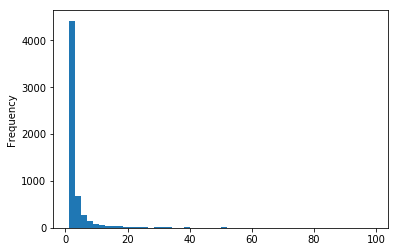

In [10]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [11]:
popularitytags = df[df>10].to_dict()
len(popularitytags)

375

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(9085, 12)


PTagsCleaned  \
Id                                 
48157550               [c#, wpf]   
48142947           [c#, mongodb]   
48166101  [asp.net-mvc, cookies]   
48164707            [ios, swift]   
48084747    [python, google-api]   

                                                      PTags  \
Id                                                            
48157550                                          [c#, wpf]   
48142947                                      [c#, mongodb]   
48166101  [asp.net-mvc, cookies, bearer-token, owin-midd...   
48164707           [ios, swift, uicollectionview, xcode9.2]   
48084747                      [python, google-api, gspread]   

                                                      TCode  
Id                                                           
48157550  < TextBox . Style >< Style TargetType =" { x :...  
48142947  class A { string id ; string text ;} class B {...  
48166101  var identity =( ClaimsIdentity ) context . Aut...  
48164707                                               None  
48084747                   sheet . insert_row ( row , index

In [13]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [14]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(9085, 375)

In [15]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [16]:
mlb.classes_

array(['ajax', 'algorithm', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'android', 'android-fragments',
       'android-intent', 'android-layout', 'android-recyclerview',
       'android-studio', 'angular', 'angular5', 'angularjs', 'animation',
       'apache', 'apache-kafka', 'apache-spark', 'api', 'arraylist',
       'arrays', 'asp.net', 'asp.net-core', 'asp.net-core-2.0',
       'asp.net-mvc', 'asp.net-web-api', 'assembly', 'asynchronous',
       'audio', 'authentication', 'authorization', 'automation',
       'aws-lambda', 'azure', 'bash', 'batch-file', 'boost', 'bootstrap-4',
       'browser', 'button', 'c', 'c#', 'c++', 'c++11', 'caching',
       'calendar', 'canvas', 'cassandra', 'cassandra-3.0', 'chart.js',
       'charts', 'checkbox', 'class', 'cmake', 'cmd', 'codeigniter',
       'components', 'cookies', 'cordova', 'css', 'css3', 'csv', 'curl',
       'd3.js', 'data-binding', 'database', 'dataframe', 'datatables',
       'date', 'datetime', 'debugging', 'deep-lea

# LDA version

In [63]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        self.lda.fit(Xtrans)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def perplexity(self, X):
        
        return self.lda.perplexity(self.transformcvect(X))
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]



#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [207]:
topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1),}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [208]:
#Filling rating
customLDA.score()

47.5

In [209]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['view', 'scroll', 'layout', 'content', 'like', 'set', 'onli',
        'problem', 'need', 'render'],
       ['method', 'get', 'observ', 'use', 'cach', 'code', 'like',
        'asynchron', 'oper', 'realm'],
       ['get', 'use', 'scope', 'ani', 'type', 'creat', 'need', 'follow',
        'want', 'u0_a110'],
       ['window', 'open', 'modal', 'work', 'use', 'ani', 'run', 'script',
        'want', 'like'],
       ['spring', 'token', 'api', 'use', 'boot', 'get', 'return',
        'respons', 'request', 'access'],
       ['cluster', 'get', 'file', 'save', 'creat', 'run', 'pod',
        'kubernet', 'firebas', 'connect'],
       ['data', 'session', 'use', 'like', 'fetch', 'way', 'get', 'want',
        'show', 'expir'],
       ['project', 'build', 'gradl', 'use', 'version', 'problem', 'modul',
        'one', 'updat', 'ani'],
       ['document', 'tri', 'get', 'express', 'code', 'set', 'assign',
        'file', 'refer', 'ani'],
       ['servic', 'googl', 'use', 'regist', 'internet', 'catego

In [210]:
#Perplexity
customLDA.perplexity(X_test)

8370.6942681397813

In [ ]:
customLDA.topicscnamed

In [211]:
customLDA.namedtopics

{'ajax': {22},
 'android': {12, 94},
 'angular': {11},
 'apache': {90},
 'api': {4, 42},
 'audio': {39},
 'browser': {23},
 'button': {48},
 'checkbox': {38},
 'class': {29, 59, 63, 88},
 'cloud': {34},
 'css': {60},
 'csv': {80},
 'date': {30},
 'docker': {57},
 'download': {80},
 'email': {87},
 'excel': {58},
 'express': {8},
 'file': {5, 44, 80, 89},
 'filter': {84},
 'function': {55, 69, 82, 93},
 'git': {73},
 'github': {73},
 'graph': {32},
 'hibernate': {90},
 'html': {11, 55, 60, 77},
 'input': {14, 43},
 'java': {12, 90},
 'javascript': {55},
 'json': {15},
 'laravel': {21},
 'list': {72},
 'magento': {70},
 'maven': {95},
 'mysql': {64},
 'object': {15, 88},
 'pdf': {25},
 'php': {21},
 'pip': {81},
 'plot': {61},
 'post': {22},
 'redirect': {23, 37},
 'rest': {42},
 'scroll': {0},
 'select': {62},
 'server': {51, 79, 89, 98},
 'session': {6},
 'spring': {4},
 'sql': {64},
 'string': {68, 69, 82},
 'text': {19, 24},
 'url': {45},
 'video': {39},
 'web': {13},
 'xamarin': {16

# TSNE reduction dimension

In [212]:
#customLDA
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

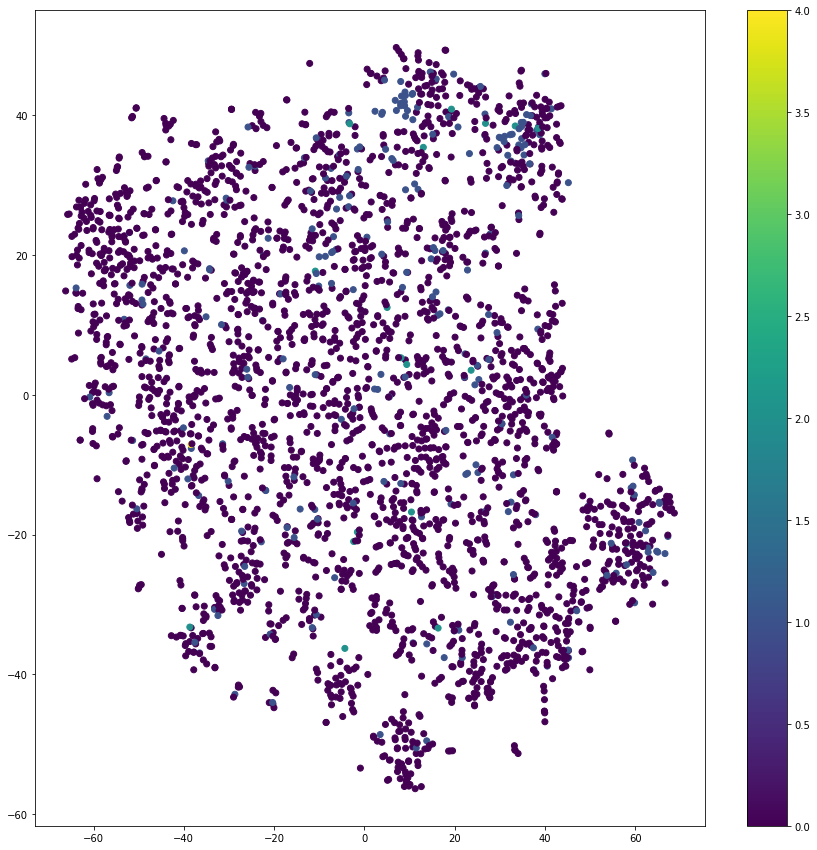

In [214]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_lda, 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [216]:
#gridsearch to optimize the parameters - LDA optimization

topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)
}

customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'clf_merge': [True, False],
             }



clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=35.16666666666667, total=  36.1s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333, score=49.33333333333333, total=  36.0s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=48.33333333333333, total=  36.3s
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.5min


[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=52.33333333333333, total=  35.0s
[CV] clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=32.33333333333333, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=49.83333333333333, total=  36.1s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=32.0, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143, score=49.833333333333336, total=  35.0s
[CV] clf_merge=True, l

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed: 10.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'lda_topic_word_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'clf_merge': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [217]:
clf.best_params_

{'clf_merge': True,
 'lda_doc_topic_prior': 0.0125,
 'lda_topic_word_prior': 0.01}

In [218]:
clf.best_score_

45.25

In [219]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [220]:
#Metrics creation

#from sklearn.metrics import fbeta_score
scorer = make_scorer(f1_score, average='micro')


In [222]:
#gridsearch to optimize the parameters - TEXT merged

customLDA = CustomLDA(**params)

parameters = {'vect_1_max_df': [1., 0.9, 0.95],
              'vect_1_max_features': [15000,18000,12000],
              'vect_1_min_df': [1, 10, 20],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.08579210167952792, total=  36.5s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.06352574985851726, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.07975705266522816, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.10321855686652219, total=  35.4s
[CV] vect_1_max_df=1.0, vect_1_max_features=18000, vect_1_min_df=1 ...


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.2min


[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=1, score=0.07975705266522816, total=  42.1s
[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=10, score=0.10321855686652219, total=  35.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.08683001531393568, total=  33.8s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.10213042771182305, total=  33.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10, score=0.08579210167952792, total=  35.7s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1, score=0.06299323562570

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 12.3min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.9, 0.95], 'vect_1_max_features': [15000, 18000, 12000], 'vect_1_min_df': [1, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [223]:
clf.best_score_

0.094505329273025046

In [224]:
clf.best_params_

{'vect_1_max_df': 1.0, 'vect_1_max_features': 15000, 'vect_1_min_df': 10}

In [225]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10473512198829521

In [226]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [228]:
#gridsearch to optimize the parameters - LDA optimization - Final round
customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*0.9), 1/(topics), 1/(topics*0.8), 1/(topics*0.7)],
              'lda_topic_word_prior':[ 1/(topics*1.1), 1/(topics), 1/(topics*0.9), 1/(topics*0.8)],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.08896505476492064, total=  35.2s
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.10335286458333333, total=  35.1s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01, score=0.08724881256850565, total=  36.2s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_top

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.8min


[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.08512505484861782, total=  36.7s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.11150152260482549, total=  36.1s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.08462286013306422, total=  36.3s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.11170501200712682, total=  36.2s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.08183188572248941, total=  33.0s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.11113734750098386, total=  33.2s


[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  7.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10,
     vec...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.011111111111111112, 0.01, 0.0125, 0.014285714285714285], 'lda_topic_word_prior': [0.00909090909090909, 0.01, 0.011111111111111112, 0.0125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [229]:
clf.best_score_

0.10033142704073042

In [230]:
clf.best_params_

{'lda_doc_topic_prior': 0.0125, 'lda_topic_word_prior': 0.011111111111111112}

In [231]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10668087049155379

In [232]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.011111111111111112,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [64]:
#Direct calculation

customLDA = CustomLDA(**params)

customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0,
     lda_topic_word_prior=0.011111111111111112, vect_1_max_df=1.0,
     vect_1_max_features=15000, vect_1_min_df=10,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=None, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [71]:
customLDA.set_params(clf_popmax=0.14)
customLDA.topic_popularity(X_train)
customLDA.too_popular_topics

[99]

In [84]:
# Topics verification - Too popular
customLDA.describe_topics(ntopwords=20, ntopics=100)[[99]]

array([['string', 'match', 'charact', 'word', 'like', 'use', 'split',
        'want', 'number', 'regex', 'tri', 'contain', 'exampl', 'would',
        'onli', 'work', 'one', 'get', 'result', 'replac']],
      dtype='<U15')

In [258]:
# Topics verification - 20 first
customLDA.describe_topics(ntopwords=20, ntopics=20)

array([['div', 'video', 'scroll', 'right', 'top', 'click', 'bottom',
        'left', 'use', 'center', 'like', 'trigger', 'ani', 'css', 'move',
        'tri', 'get', 'would', 'posit', 'content'],
       ['event', 'stop', 'way', 'expand', 'current', 'calendar', 'volum',
        'feed', 'collaps', 'work', 'drag', 'use', 'name', 'past', 'tell',
        'get', 'wo', 'open', 'one', 'code'],
       ['view', 'control', 'chart', 'byte', 'serial', 'set', 'nil',
        'first', 'code', 'back', 'second', 'angularj', 'anoth', 'bar',
        'load', 'problem', 'follow', 'insid', 'one', 'viewcontrol'],
       ['access', 'token', 'use', 'password', 'secur', 'get', 'api',
        'facebook', 'request', 'work', 'auth', 'link', 'login', 'role',
        'need', 'spring', 'account', 'refresh', 'oauth', 'store'],
       ['state', 'updat', 'prop', 'this', 'png', 'chang', 'doe', 'like',
        'textview', 'code', 'differ', 'bound', 'line', 'use', 'approach',
        'tri', 'also', 'subtract', 'problem', 'be

In [67]:
print(len(customLDA.namedtopics))
customLDA.namedtopics

60


{'android': {23, 97},
 'angular': {89},
 'api': {15, 84},
 'browser': {31},
 'cassandra': {58},
 'class': {46, 53},
 'cordova': {35},
 'css': {60},
 'csv': {92},
 'date': {48},
 'django': {9},
 'docker': {30},
 'excel': {65},
 'file': {24, 27, 41, 92, 98},
 'filter': {63},
 'function': {69},
 'git': {61},
 'gridview': {37},
 'header': {88},
 'html': {60},
 'https': {75},
 'import': {75},
 'input': {74},
 'java': {23, 42},
 'join': {38},
 'json': {59},
 'lambda': {37},
 'list': {32, 91},
 'listview': {91},
 'matrix': {40},
 'mongodb': {19},
 'mysql': {34},
 'nginx': {21},
 'npm': {80},
 'object': {46, 57},
 'pdf': {89},
 'php': {65},
 'plot': {71},
 'post': {15, 93},
 'postgresql': {62},
 'python': {5},
 'redirect': {75},
 'redux': {4},
 'search': {96},
 'select': {90},
 'server': {45, 52, 84},
 'session': {85},
 'spring': {42},
 'sql': {34},
 'ssl': {4},
 'string': {14, 88, 99},
 'swift': {81},
 'tensorflow': {10},
 'text': {63},
 'url': {79},
 'web': {42, 54},
 'webpack': {30},
 'word

In [72]:
customLDA.topicsnamed

{0: [],
 1: [],
 2: [],
 3: [],
 4: ['ssl', 'redux'],
 5: ['python'],
 6: [],
 7: [],
 8: [],
 9: ['django'],
 10: ['tensorflow'],
 11: [],
 12: [],
 13: [],
 14: ['string'],
 15: ['post', 'api'],
 16: [],
 17: [],
 18: [],
 19: ['mongodb'],
 20: ['xcode'],
 21: ['nginx'],
 22: [],
 23: ['java', 'android'],
 24: ['file'],
 25: [],
 26: [],
 27: ['file'],
 28: [],
 29: [],
 30: ['docker', 'webpack'],
 31: ['browser'],
 32: ['list'],
 33: [],
 34: ['sql', 'mysql'],
 35: ['cordova'],
 36: [],
 37: ['lambda', 'gridview'],
 38: ['join'],
 39: [],
 40: ['matrix'],
 41: ['file'],
 42: ['spring', 'java', 'web'],
 43: [],
 44: [],
 45: ['server'],
 46: ['object', 'class'],
 47: [],
 48: ['date'],
 49: [],
 50: [],
 51: [],
 52: ['server'],
 53: ['class'],
 54: ['web'],
 55: [],
 56: [],
 57: ['object'],
 58: ['cassandra'],
 59: ['json'],
 60: ['html', 'css'],
 61: ['git'],
 62: ['postgresql'],
 63: ['text', 'filter'],
 64: [],
 65: ['php', 'excel'],
 66: [],
 67: [],
 68: [],
 69: ['function'],

In [73]:
mlb.inverse_transform(y_test[:10])

[('c#', 'javascript'),
 ('ssl',),
 ('mysql', 'sql'),
 ('angularjs', 'javascript', 'jquery'),
 ('entity-framework',),
 ('delphi',),
 ('javascript', 'node.js'),
 ('css', 'html', 'javascript'),
 ('css', 'html', 'javascript', 'jquery'),
 ('css', 'html', 'javascript', 'jquery')]

In [74]:
customLDA.predict_word(X_test[:10])

array([['object', 'array', 'valu', 'loop', 'want', 'method', 'json', 'get',
        'call', 'data', 'like', 'convert', 'data', 'would', 'string'],
       ['step', 'use', 'detect', 'server', 'bundl', 'python', 'instal',
        'error', 'messag', 'fail', 'show', 'code', 'fragment', 'whi',
        'work'],
       ['python', 'instal', 'error', 'messag', 'fail', 'queri', 'column',
        'sql', 'mysql', 'use', 'two', 'use', 'data', 'list', 'one'],
       ['two', 'use', 'data', 'list', 'one', 'like', 'convert', 'data',
        'would', 'string', 'show', 'code', 'fragment', 'whi', 'work'],
       ['calcul', 'total', 'categori', 'show', 'hour', 'function',
        'return', 'valu', 'call', 'work', 'datafram', 'valu', 'column',
        'panda', 'data'],
       ['select', 'form', 'box', 'option', 'submit', 'send', 'app',
        'receiv', 'data', 'notif', 'implement', 'base', 'method', 'use',
        'way'],
       ['file', 'directori', 'folder', 'packag', 'use', 'file', 'csv',
        'upload

In [75]:
mlb.inverse_transform(customLDA.predict(X_test[:10]))

[('json', 'object', 'string'),
 ('python', 'server'),
 ('list', 'mysql', 'python', 'sql'),
 ('list', 'string'),
 ('function',),
 ('select',),
 ('csv', 'file'),
 ('css', 'html', 'json'),
 ('browser', 'css', 'html'),
 ()]

In [88]:
predict = mlb.inverse_transform(customLDA.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print()

TRUE --> ('c#', 'javascript')
PRED --> ('json', 'object', 'string')

TRUE --> ('ssl',)
PRED --> ('python', 'server')

TRUE --> ('mysql', 'sql')
PRED --> ('list', 'mysql', 'python', 'sql')

TRUE --> ('angularjs', 'javascript', 'jquery')
PRED --> ('list', 'string')

TRUE --> ('entity-framework',)
PRED --> ('function',)

TRUE --> ('delphi',)
PRED --> ('select',)

TRUE --> ('javascript', 'node.js')
PRED --> ('csv', 'file')

TRUE --> ('css', 'html', 'javascript')
PRED --> ('css', 'html', 'json')

TRUE --> ('css', 'html', 'javascript', 'jquery')
PRED --> ('browser', 'css', 'html')

TRUE --> ('css', 'html', 'javascript', 'jquery')
PRED --> ()

TRUE --> ('android',)
PRED --> ('gridview', 'lambda', 'redux', 'ssl')

TRUE --> ('machine-learning', 'r')
PRED --> ('file', 'post', 'tensorflow')

TRUE --> ('css', 'html')
PRED --> ('join',)

TRUE --> ('python',)
PRED --> ('filter', 'git', 'text')

TRUE --> ('json', 'mongodb', 'r')
PRED --> ()

TRUE --> ('amazon-web-services',)
PRED --> ('https', 'impor

PRED --> ('browser',)

TRUE --> ('asp.net-core', 'c#', 'razor', 'visual-studio-2017')
PRED --> ('web',)

TRUE --> ('c#',)
PRED --> ('api', 'server')

TRUE --> ('java', 'jboss')
PRED --> ('file',)

TRUE --> ('c#', 'winforms')
PRED --> ()

TRUE --> ('c#',)
PRED --> ('swift', 'url', 'web')

TRUE --> ('android',)
PRED --> ('file', 'plot')

TRUE --> ('ruby-on-rails',)
PRED --> ('object',)

TRUE --> ('eclipse', 'intellij-idea', 'java')
PRED --> ('class', 'object')

TRUE --> ('jquery',)
PRED --> ('filter', 'select', 'text')

TRUE --> ('algorithm', 'c++')
PRED --> ('class', 'xml')

TRUE --> ('ruby', 'soap')
PRED --> ('api', 'post', 'string')

TRUE --> ('design-patterns', 'multithreading')
PRED --> ('mongodb', 'object')

TRUE --> ('java', 'json', 'rest', 'spring-boot')
PRED --> ('class', 'header', 'json', 'string')

TRUE --> ('r', 'sql-server', 'tsql')
PRED --> ('web',)

TRUE --> ('dynamic', 'flask')
PRED --> ('function', 'url')

TRUE --> ('ajax', 'javascript', 'jquery', 'php', 'yii2')
PRED -->

TRUE --> ('spring-data-jpa',)
PRED --> ('postgresql',)

TRUE --> ('cmake',)
PRED --> ('docker', 'file', 'json', 'webpack')

TRUE --> ('sql', 'vba')
PRED --> ('function', 'mysql', 'sql', 'swift')

TRUE --> ('matplotlib', 'python')
PRED --> ('https', 'import', 'redirect')

TRUE --> ('jquery',)
PRED --> ('gridview', 'lambda', 'mongodb')

TRUE --> ('ios',)
PRED --> ()

TRUE --> ('android',)
PRED --> ()

TRUE --> ('excel-vba', 'vba')
PRED --> ('excel', 'list', 'listview', 'php')

TRUE --> ('java', 'swing')
PRED --> ('class', 'nginx')

TRUE --> ('oracle', 'ruby-on-rails')
PRED --> ('session',)

TRUE --> ('android',)
PRED --> ('gridview', 'lambda', 'list', 'listview')

TRUE --> ('eclipse', 'java')
PRED --> ('python', 'xcode')

TRUE --> ('numpy',)
PRED --> ('object',)

TRUE --> ('c', 'memory')
PRED --> ()

TRUE --> ('numpy', 'python', 'scipy')
PRED --> ('function', 'json')

TRUE --> ('asp.net-core',)
PRED --> ('url', 'web')

TRUE --> ('mongodb', 'node.js', 'npm')
PRED --> ('cassandra',)

TRUE 

TRUE --> ('c#', 'java', 'soap', 'wcf', 'web-services')
PRED --> ('api', 'docker', 'server', 'webpack')

TRUE --> ('ios', 'objective-c')
PRED --> ('class', 'object')

TRUE --> ('android',)
PRED --> ('url',)

TRUE --> ('angular', 'typescript')
PRED --> ('file', 'npm')

TRUE --> ('math',)
PRED --> ('mongodb',)

TRUE --> ('spring-boot',)
PRED --> ('api', 'server')

TRUE --> ('list', 'python')
PRED --> ('python',)

TRUE --> ('database', 'mysql')
PRED --> ('mysql', 'sql')

TRUE --> ('python', 'recursion')
PRED --> ('docker', 'string', 'webpack')

TRUE --> ('firebase', 'firebase-database', 'ios', 'swift', 'uitableview')
PRED --> ('list', 'listview')

TRUE --> ('css', 'html', 'ios', 'jquery')
PRED --> ()

TRUE --> ('iis',)
PRED --> ('file',)

TRUE --> ('javascript',)
PRED --> ('csv', 'file', 'postgresql')

TRUE --> ('delphi',)
PRED --> ('git', 'xcode')

TRUE --> ('ruby-on-rails',)
PRED --> ('string',)

TRUE --> ('lambda', 'linq')
PRED --> ('string',)

TRUE --> ('exception', 'python', 'python-3


TRUE --> ('list', 'python')
PRED --> ('list', 'listview', 'string')

TRUE --> ('list', 'python')
PRED --> ('git', 'list', 'listview')

TRUE --> ('python', 'python-3.x')
PRED --> ('git', 'search')

TRUE --> ('java', 'session')
PRED --> ()

TRUE --> ('ios', 'xamarin')
PRED --> ('browser',)

TRUE --> ('class', 'javascript')
PRED --> ('css', 'html')

TRUE --> ('ios',)
PRED --> ('file', 'swift')

TRUE --> ('android', 'image', 'opencv')
PRED --> ('tensorflow',)

TRUE --> ('ios', 'swift')
PRED --> ()

TRUE --> ('c#', 'canvas', 'wpf')
PRED --> ('nginx',)

TRUE --> ('hive',)
PRED --> ('file', 'join', 'mysql', 'sql')

TRUE --> ('python', 'python-3.x')
PRED --> ('file',)

TRUE --> ('jquery',)
PRED --> ('css', 'gridview', 'html', 'lambda')

TRUE --> ('jquery', 'twitter-bootstrap')
PRED --> ('browser', 'redux', 'ssl')

TRUE --> ('batch-file', 'cmd')
PRED --> ('file',)

TRUE --> ('javascript', 'vue.js')
PRED --> ('function', 'npm')

TRUE --> ('amazon-ec2',)
PRED --> ('mysql', 'plot', 'sql')

TRUE -

PRED --> ('excel', 'file', 'php')

TRUE --> ('image', 'python')
PRED --> ('wordpress',)

TRUE --> ('android', 'c++', 'ios')
PRED --> ('function',)

TRUE --> ('flask', 'python')
PRED --> ('api', 'server')

TRUE --> ('java', 'logging')
PRED --> ('json',)

TRUE --> ('asp.net-core', 'c#', 'linux', 'ssl')
PRED --> ('header', 'string', 'web')

TRUE --> ('android', 'java', 'sockets')
PRED --> ()

TRUE --> ('powershell',)
PRED --> ('file',)

TRUE --> ('android',)
PRED --> ()

TRUE --> ('database', 'ruby', 'ruby-on-rails')
PRED --> ('date', 'filter', 'text')

TRUE --> ('tensorflow',)
PRED --> ('server', 'tensorflow')

TRUE --> ('html', 'php')
PRED --> ('browser', 'input')

TRUE --> ('laravel', 'laravel-5', 'php')
PRED --> ('string',)

TRUE --> ('apache-spark', 'hadoop', 'java')
PRED --> ('server',)

TRUE --> ('android', 'java', 'listview')
PRED --> ('function',)

TRUE --> ('django', 'python', 'url')
PRED --> ('django', 'https', 'import', 'redirect')

TRUE --> ('function', 'python', 'python-3.x'

PRED --> ()

TRUE --> ('sql-server', 'ssis')
PRED --> ('date', 'file')

TRUE --> ('python', 'tkinter')
PRED --> ('function', 'wordpress')

TRUE --> ('c++', 'templates')
PRED --> ('file', 'wordpress')

TRUE --> ('c', 'c++')
PRED --> ('function', 'object')

TRUE --> ('c#', 'oracle')
PRED --> ('web',)

TRUE --> ('eclipse', 'java')
PRED --> ('file',)

TRUE --> ('awk', 'bash', 'linux', 'shell')
PRED --> ('file', 'string')

TRUE --> ('java', 'oracle', 'sql')
PRED --> ('file', 'join', 'swift')

TRUE --> ('javascript', 'vue.js', 'webpack')
PRED --> ('css', 'html', 'list')

TRUE --> ('jboss',)
PRED --> ('web',)

TRUE --> ('xamarin.forms',)
PRED --> ()

TRUE --> ('cassandra',)
PRED --> ('cassandra', 'string')

TRUE --> ('angularjs',)
PRED --> ('server',)

TRUE --> ('c#', 'ffmpeg')
PRED --> ('git',)

TRUE --> ('multithreading', 'ruby')
PRED --> ('post',)

TRUE --> ('java',)
PRED --> ('input', 'list')

TRUE --> ('vba',)
PRED --> ('file', 'xml')

TRUE --> ('c#', 'xamarin', 'xamarin.forms')
PRED -->

TRUE --> ('asynchronous', 'python', 'python-3.x')
PRED --> ('file', 'string')

TRUE --> ('android', 'ios', 'xamarin', 'xamarin.forms')
PRED --> ('gridview', 'lambda', 'select')

TRUE --> ('python-3.x', 'web-scraping')
PRED --> ('string',)

TRUE --> ('eclipse', 'java', 'jboss')
PRED --> ('android', 'java', 'server')

TRUE --> ('nginx', 'ssl')
PRED --> ('api', 'post', 'server')

TRUE --> ('javascript',)
PRED --> ('json', 'xcode')

TRUE --> ('mongodb', 'multiprocessing', 'python', 'python-requests')
PRED --> ('git', 'server')

TRUE --> ('r',)
PRED --> ('header', 'server', 'string')

TRUE --> ('arrays', 'objective-c')
PRED --> ('list', 'object', 'select')

TRUE --> ('java',)
PRED --> ('date', 'filter', 'text')

TRUE --> ('class', 'python')
PRED --> ('file', 'string')

TRUE --> ('c#', 'linq', 'sql-server', 'stored-procedures')
PRED --> ('header', 'json', 'mysql', 'sql', 'string')

TRUE --> ('c#', 'docker')
PRED --> ('docker', 'nginx', 'webpack')

TRUE --> ('asp.net-web-api', 'rest')
PRED --

# NMF version

In [17]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':.05, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #NMF preparation
        self.nmf = NMF(**self.nmf_params)
        self.nmf.fit(Xtrans)
        
        self.components_ = self.nmf.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        nmf = self.nmf.transform(self.transformcvect(X))
        return nmf
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5 #self.nmf_params['n_components']//10
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]
        

#customNMF = CustomNMF()



In [54]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

customNMF = CustomNMF(**params)
customNMF.fit(X_train, y_train)

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=5, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1))

In [55]:
#Topic popularity
customNMF.topic_pop_

{1: 113,
 2: 897,
 3: 40,
 4: 127,
 5: 99,
 6: 341,
 7: 595,
 8: 525,
 9: 316,
 10: 623,
 11: 602,
 12: 177,
 13: 64,
 14: 125,
 15: 203,
 16: 199,
 17: 945,
 18: 73,
 19: 186,
 20: 209,
 21: 161,
 22: 224,
 23: 196,
 24: 221,
 25: 370,
 26: 79,
 27: 65,
 28: 158,
 29: 205,
 30: 72,
 31: 89,
 32: 82,
 33: 350,
 34: 176,
 35: 129,
 36: 173,
 37: 266,
 38: 236,
 39: 343,
 40: 186,
 41: 187,
 42: 140,
 43: 204,
 44: 188,
 45: 101,
 46: 187,
 47: 110,
 48: 142,
 49: 126,
 50: 237,
 51: 334,
 52: 221,
 53: 551,
 54: 236,
 55: 354,
 56: 297,
 57: 318,
 58: 267,
 59: 290,
 60: 524,
 61: 198,
 62: 273,
 63: 188,
 64: 675,
 65: 150,
 66: 246,
 67: 317,
 68: 266,
 69: 322,
 70: 402,
 71: 292,
 72: 243,
 73: 273,
 74: 324,
 75: 453,
 76: 540,
 77: 327,
 78: 633,
 79: 293,
 80: 363,
 81: 279,
 82: 286,
 83: 293,
 84: 550,
 85: 510,
 86: 365,
 87: 329,
 88: 831,
 89: 465,
 90: 359,
 91: 359,
 92: 515,
 93: 491,
 94: 398,
 95: 255,
 96: 723,
 97: 563,
 98: 420,
 99: 407}

In [56]:
#Topics over represented in our set
customNMF.too_popular_topics

[17]

In [57]:
customNMF.score()

49.5

In [58]:
#Topic description : number --> Name
customNMF.topicsnamed

{0: [],
 1: ['matrix'],
 2: ['file'],
 3: ['button'],
 4: ['mysql'],
 5: ['object', 'filter'],
 6: [],
 7: [],
 8: ['function', 'lambda'],
 9: ['class'],
 10: [],
 11: ['checkbox'],
 12: ['javascript'],
 13: ['pdf', 'web', 'login'],
 14: [],
 15: ['login'],
 16: [],
 17: [],
 18: [],
 19: ['date'],
 20: ['download', 'pip'],
 21: ['server', 'sql'],
 22: ['python', 'django'],
 23: ['php', 'ajax', 'wordpress'],
 24: ['string'],
 25: ['sql', 'join', 'mysql'],
 26: ['api', 'rest'],
 27: ['checkbox'],
 28: ['xamarin'],
 29: [],
 30: ['web'],
 31: ['docker'],
 32: ['laravel', 'checkbox'],
 33: [],
 34: ['json'],
 35: [],
 36: [],
 37: ['select'],
 38: ['web', 'rest', 'wcf'],
 39: [],
 40: [],
 41: [],
 42: ['npm'],
 43: ['search', 'filter'],
 44: [],
 45: ['email'],
 46: [],
 47: ['spring'],
 48: [],
 49: ['import', 'typescript', 'webpack'],
 50: ['http'],
 51: [],
 52: [],
 53: [],
 54: ['sql'],
 55: [],
 56: [],
 57: [],
 58: ['html', 'javascript', 'css'],
 59: ['java'],
 60: ['time'],
 61:

In [59]:
print(len(customNMF.namedtopics))
customNMF.namedtopics

68


{'ajax': {23, 92},
 'android': {67},
 'angular': {87},
 'api': {26},
 'button': {3},
 'calendar': {80},
 'checkbox': {11, 27, 32},
 'class': {9},
 'css': {58, 66, 91},
 'date': {19},
 'django': {22, 68, 86, 92},
 'docker': {31},
 'download': {20, 98},
 'elasticsearch': {86},
 'email': {45},
 'excel': {72},
 'express': {97},
 'file': {2},
 'filter': {5, 43},
 'function': {8},
 'git': {99},
 'html': {58},
 'http': {50},
 'import': {49},
 'input': {71},
 'java': {59},
 'javascript': {12, 58},
 'join': {25, 62},
 'json': {34},
 'lambda': {8},
 'laravel': {32},
 'list': {62},
 'listview': {61},
 'login': {13, 15},
 'matplotlib': {82},
 'matrix': {1},
 'mysql': {4, 25, 69, 89},
 'nginx': {75},
 'npm': {42},
 'object': {5},
 'pdf': {13},
 'php': {23},
 'pip': {20},
 'plot': {82},
 'python': {22},
 'redirect': {85},
 'regex': {97},
 'rest': {26, 38},
 'search': {43},
 'select': {37},
 'server': {21},
 'shell': {74},
 'spring': {47},
 'sql': {21, 25, 54, 89},
 'string': {24},
 'struct': {84},
 

In [60]:
# Topics verification
customNMF.describe_topics(ntopwords=20, ntopics=100)[[17]]

array([['like', 'would', 'look', 'someth', 'way', 'use', 'possibl', 'know',
        'exampl', 'ani', 'could', 'make', 'current', 'seem', 'need',
        'implement', 'better', 'right', 'find', 'appreci']],
      dtype='<U19')

In [61]:
#customNMF
X_mnf = customNMF.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_mnf)

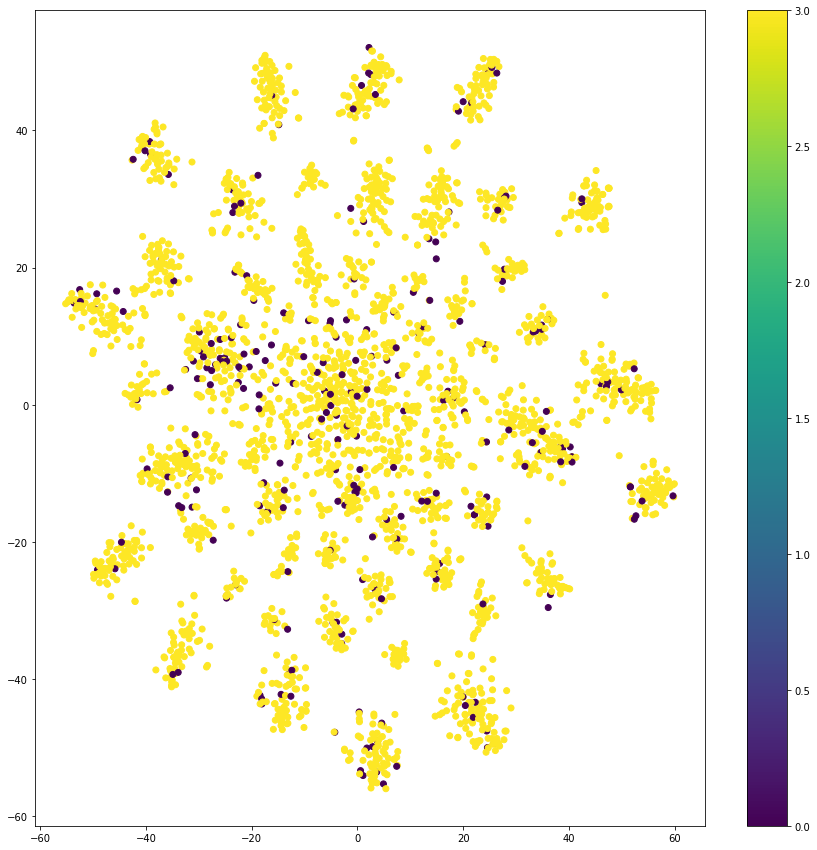

In [62]:
# plot the result according the topics
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_mnf, 0)[:, 3] ## Change the topic number here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

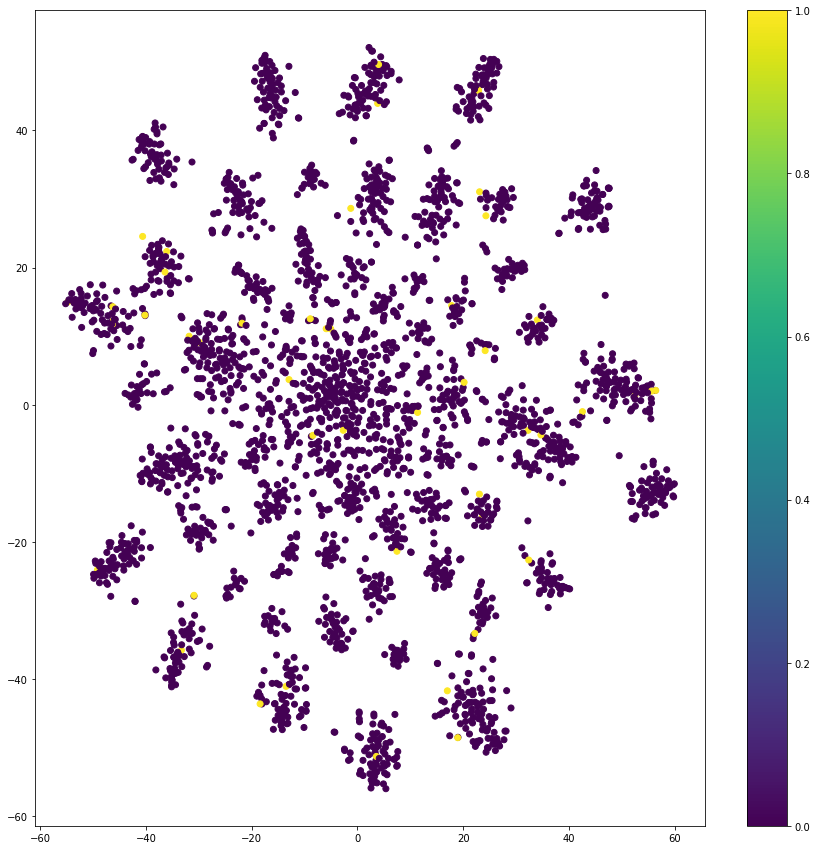

In [63]:
# plot the result according the labels
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = y_test[:, 21]  ## Change the tag position here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [71]:
predict = mlb.inverse_transform(customNMF.predict(X_test))
truetag = mlb.inverse_transform(y_test)
wordtag = customNMF.predict_word(X_test)

for prediction, tags, post, keywords in zip(predict, truetag, list(X_test['TText']), wordtag):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('KEYW --> {}'.format(keywords))
    print('--------------------------------------------')

hello need advic add modul exist nginx instal need add http_ssl_modul server got use nginx -v nginx version nginx/1.9.9 built gcc 4.8.4 ubuntu 4.8.4-2ubuntu1~14.04.1 configur argument -- prefix=/etc/nginx -- sbin-path=/usr/sbin/nginx -- conf-path=/etc/nginx/nginx.conf -- error-log-path=/var/log/nginx/error.log -- http-log-path=/var/log/nginx/access.log -- pid-path=/var/run/nginx.pid -- lock-path=/var/run/nginx.lock -- user=nginx -- group=nginx -- with-http_realip_modul -- with-http_addition_modul -- with-http_sub_modul -- with-http_dav_modul -- with-http_flv_modul -- with-http_mp4_modul -- with-http_random_index_modul -- with-http_secure_link_modul -- with-http_stub_status_modul -- with-http_auth_request_modul -- with-mail -- with-file-aio -- with-ipv6 -- with-cc-opt='-o2 -g -pipe -wp -d_fortify_source=2 -fexcept -fstack-protector -- param=ssp-buffer-size=4 -m64 -mtune=gener add modul server tri use ./configur -- -- http_ssl_modul command say file directori thank ani advanc

TRUE --> (

KEYW --> ['field' 'index' 'django' 'elasticsearch' 'admin' 'add' 'ad' 'new' 'header'
 'custom' 'match' 'charact' 'word' 'regex' 'express']
--------------------------------------------
setup suppos want group year month —— see data januari februari design characterist function everi time-data record gatherf would calcul valu groupbi distinguish time object final object develop function gather_bi generat effort general case datedat might column could n't group one one tri lead data must 1-dimension error

TRUE --> ('dataframe', 'group-by', 'pandas', 'python')
PRED --> ('function', 'lambda')
KEYW --> ['record' 'delet' 'remov' 'insert' 'process' 'data' 'frame' 'fram' 'fetch'
 'stream' 'function' 'call' 'lambda' 'argument' 'pass']
--------------------------------------------
tri implement custom bodi type would hold pars json tree object task seem pretti natur ca n't find way generat non-chunk http messag carri json use beast rest client/serv implement wrap libmicrohttpd libcurl would prefe

PRED --> ('express', 'regex')
KEYW --> ['add' 'ad' 'new' 'header' 'custom' 'whi' 'doe' 'understand' 'know' 'oper'
 'match' 'charact' 'word' 'regex' 'express']
--------------------------------------------
tri concat string input xml xslt logic expect three valu come sequenc `` '' seper come sequenc pleas help

TRUE --> ('xslt',)
PRED --> ('checkbox', 'input', 'xml')
KEYW --> ['xml' 'tag' 'child' 'textview' 'xsd' 'input' 'use' 'ng' 'bar' 'output'
 'valu' 'checkbox' 'total' 'exampl' 'assign']
--------------------------------------------
new sql pleas forgiv bungl lexicon 'm tri figur specifi claus isol row id match id occur round regardless round prefer output would id occur round want row id exclud id n't occur round i.e id ani help would appreci ca n't seem formul search turn answer problem work mysql make differ

TRUE --> ('mysql',)
PRED --> ('express', 'matrix', 'regex', 'struct')
KEYW --> ['match' 'charact' 'word' 'regex' 'express' 'name' 'id' 'sheet' 'countri'
 'struct' 'row' 'matri


TRUE --> ('arrays', 'html', 'javascript', 'jquery')
PRED --> ('css', 'express', 'regex', 'select')
KEYW --> ['select' 'option' 'dropdown' 'box' 'want' 'match' 'charact' 'word' 'regex'
 'express' 'element' 'css' 'remov' 'want' 'hover']
--------------------------------------------
small-scal project work fine use dictionari chang would basic mean start let 's say two differ dictionari dict1 dict2 one second one want find wherev first word first dictionari equal word second one dictionari n't length like exampl find divid valu want sort use bit java tri far tri make differ list list dict1 key list dict1 valu dict2 realiz n't even know check dict2 ani similar element dict1 tri make extra valu dictionari sort index would kind get somewher turn dict2.key n't iter either would turn believ use differ list tri compar somehow use veri wrong

TRUE --> ('dictionary', 'python')
PRED --> ('express', 'join', 'list', 'regex')
KEYW --> ['key' 'primari' 'foreign' 'constraint' 'count' 'match' 'charact' 

--------------------------------------------
wrote queri laravel queri work perfect mac howev colleagu ran queri window machin take forev wrote one queri work perfect window mac question although queri select onli requir column take forev queri take column join tabl execut faster whi happen differ doe make run queri differ machin time differ signific

TRUE --> ('laravel', 'mysql')
PRED --> ('sql', 'time')
KEYW --> ['queri' 'sql' 'result' 'nest' 'claus' 'command' 'execut' 'window'
 'powershel' 'use' 'time' 'one' 'second' 'first' 'two']
--------------------------------------------
tri import ipcrender react app get error messag requir defin

TRUE --> ('javascript', 'node.js', 'reactjs', 'webpack')
PRED --> ('import', 'typescript', 'webpack')
KEYW --> ['react' 'nativ' 'nat' 'rout' 'router' 'modul' 'import' 'librari'
 'typescript' 'webpack' 'app' 'io' 'devic' 'deploy' 'open']
--------------------------------------------
print onli line exist four given input file shown input file onli /dev

KEYW --> ['store' 'procedur' 'paramet' 'sql' 'mysql' 'url' 'websit' 'redirect' 'com'
 'link' 'show' 'screen' 'messag' 'onli' 'problem']
--------------------------------------------
run code first url noth seem happen last print statement hit run second link abl get document need websit save text file continu pars bunch link cycl work tri debug know sure problem

TRUE --> ('python', 'python-2.7')
PRED --> ('file', 'redirect')
KEYW --> ['url' 'websit' 'redirect' 'com' 'link' 'file' 'folder' 'upload' 'read'
 'directori' 'work' 'fine' 'tri' 'use' 'doe']
--------------------------------------------
want modifi python script window origin author seem compil program window execut possibl run script without compil tri follow command prompt window say doe recogn python need instal correct command line syntax accord doc correct way run execut thank

TRUE --> ('python',)
PRED --> ('django', 'python', 'shell')
KEYW --> ['command' 'execut' 'window' 'powershel' 'use' 'script' 'folder' 'shell'
 'batc

TRUE --> ('javascript',)
PRED --> ('matplotlib', 'plot')
KEYW --> ['number' 'digit' 'count' 'random' 'calcul' 'whi' 'doe' 'understand' 'know'
 'oper' 'plot' 'axi' 'point' 'matplotlib' 'bar']
--------------------------------------------
last night app bootstrap drop work product develop ad bootstrap collaps anoth section page drop onli work develop collaps work fine understand somehow jqueri relat seen ton post similar question veri frustrat test push heroku everi time tri someth new dure may delet line application.j becaus seem work put product look commit origin meantim application.j application.html.erb

TRUE --> ('ruby-on-rails', 'twitter-bootstrap-3')
PRED --> ('git',)
KEYW --> ['git' 'commit' 'branch' 'repo' 'clone' 'record' 'delet' 'remov' 'insert'
 'process' 'work' 'fine' 'tri' 'use' 'doe']
--------------------------------------------
stuck configur sonarqub version 5.6.2 sonarqub scanner 2.5.1 maven 3.2.5 multi-modul java project defin sonar.java.binaries=target/class still fac

KEYW --> ['command' 'execut' 'window' 'powershel' 'use' 'load' 'process' 'webview'
 'content' 'loader' 'null' 'properti' 'crash' 'check' 'card']
--------------------------------------------
want creat oauth2 server vertx use springboot oauth2 ani way tri vertx 's oauth2 unsuccess

TRUE --> ('java', 'oauth-2.0', 'spring-boot')
PRED --> ('server', 'sql')
KEYW --> ['server' 'client' 'side' 'sql' 'socket' 'creat' 'new' 'dynam' 'exist'
 'directori' 'like' 'would' 'look' 'someth' 'way']
--------------------------------------------
list dict want split valu dict per key current possibl achiev via map n't call map multipl time onc

TRUE --> ('functional-programming', 'python')
PRED --> ('checkbox',)
KEYW --> ['map' 'googl' 'marker' 'cloud' 'sheet' 'valu' 'checkbox' 'total' 'exampl'
 'assign' 'key' 'primari' 'foreign' 'constraint' 'count']
--------------------------------------------
updat src attribut imag tag abov imag tag dummi src valu use file upload file get upload assign src img tag file

--------------------------------------------
use kubectl kop 1.8 spin cluster aw use kop client certif present string client-certificate-data field ~/.kube/config creat follow valu unless wrong start kubernet 1.4 valu organitazion interpet group inform string associ cn valu so-cal user sinc k8s doe inher concept see permiss associ system master group and/or kubecfg user whi entri ~/.kube/config incorpor kubecfg user rather user bear cluster name anoth user name admin end day user perform api call execut kubectl command updat tri mess valu client-certificate-data ~/.kube/config got error tls privat key doe match public key assum mean use x509 base auth make api call kubecfg

TRUE --> ('kubernetes',)
PRED --> ('checkbox', 'struct')
KEYW --> ['name' 'id' 'sheet' 'countri' 'struct' 'command' 'execut' 'window'
 'powershel' 'use' 'valu' 'checkbox' 'total' 'exampl' 'assign']
--------------------------------------------
current follow html css html css issu resiz browser window imag left doe r

KEYW --> ['cell' 'excel' 'sheet' 'rang' 'vba' 'row' 'matrix' 'dataset' 'header'
 'duplic' 'field' 'index' 'django' 'elasticsearch' 'admin']
--------------------------------------------
read effect java rule defens copi told explicit two time copi occur everi data transact follow rule exampl code thought seem somewhat redund understand correct ani better way

TRUE --> ('java',)
PRED --> ('java', 'time')
KEYW --> ['data' 'frame' 'fram' 'fetch' 'stream' 'java' 'lang' 'org' 'eclips' 'jar'
 'time' 'one' 'second' 'first' 'two']
--------------------------------------------
'm tri reciev data pretti big tabl bigtabl getrow function rearrang data faster calcul specif inform problem valu n't exist -- nil thought 'd taken care ad if-stat check first valu doe even exist still get error thank help function line error getrow -function get valu two dimension array point b `` diagon '' downward

TRUE --> ('debugging',)
PRED --> ('checkbox', 'function', 'lambda')
KEYW --> ['valu' 'checkbox' 'total' 'ex

TRUE --> ('rust',)
PRED --> ('filter', 'matplotlib', 'plot', 'search')
KEYW --> ['plot' 'axi' 'point' 'matplotlib' 'bar' 'get' 'tri' 'follow' 'use'
 'result' 'search' 'result' 'filter' 'sort' 'find']
--------------------------------------------
attempt util knn iri data set `` hello world '' machin learn use jupyt notebook anaconda clear document step `` nameerror name knn defin '' except current thrown attempt use knn.fit x miss attempt test definit knn call print knn get follow output code

TRUE --> ('jupyter-notebook', 'machine-learning', 'python')
PRED --> ('struct',)
KEYW --> ['name' 'id' 'sheet' 'countri' 'struct' 'output' 'print' 'loop' 'program'
 'consol' 'data' 'frame' 'fram' 'fetch' 'stream']
--------------------------------------------
'm tri dispacth async action redux thunk code n't work consol throw error error action must plain object use custom middlewar async action well code action code like compon import action put connect react-redux call `` this.props.newlaunch obj

creat servic downloadservice1 use object downloaddata1 want perform download oper simultan use object downloaddata1 downloaddata2 dont want creat extact copi downloadservice1 say downloadservice2 work downloaddata2 ani way creat multipl instanc servic achiev want

TRUE --> ('android', 'service')
PRED --> ('android', 'rest', 'wcf', 'web')
KEYW --> ['servic' 'web' 'rest' 'call' 'wcf' 'creat' 'new' 'dynam' 'exist'
 'directori' 'android' 'studio' 'visual' 'devic' 'applic']
--------------------------------------------
face issu regard map composit class data come server dataset dssubjectmark unabl map becaus contain two subject angular react differ row exampl angular row react row dataset want make object composit class data singl object code pleas help resolv issu

TRUE --> ('c#',)
PRED --> ('angular',)
KEYW --> ['react' 'nativ' 'nat' 'rout' 'router' 'angular' 'chart' 'js' 'pie'
 'legend' 'data' 'frame' 'fram' 'fetch' 'stream']
--------------------------------------------
want creat anim c

--------------------------------------------
'm tri set multipl field one line django crispi form 's work 's got wrong

TRUE --> ('django', 'python')
PRED --> ('django', 'elasticsearch', 'xamarin')
KEYW --> ['field' 'index' 'django' 'elasticsearch' 'admin' 'form' 'submit' 'xamarin'
 'fill' 'product' 'set' 'cooki' 'true' 'properti' 'paramet']
--------------------------------------------
current array letter avgx avgi element posit array use bubbl sort sort avgx valu code move element time want use array custom defin object merg togeth sure declar one need chang bubbl sort

TRUE --> ('android', 'java')
PRED --> ('checkbox', 'css', 'javascript')
KEYW --> ['element' 'css' 'remov' 'want' 'hover' 'array' 'javascript' 'index'
 'empti' '2d' 'valu' 'checkbox' 'total' 'exampl' 'assign']
--------------------------------------------
load mjpg stream thumbnail webview fullscreen webview click thumbnail show fullscreen quick right load onc thumbnail user click thumbnail load fullscreen view problem 

PRED --> ('file', 'shell')
KEYW --> ['file' 'folder' 'upload' 'read' 'directori' 'script' 'folder' 'shell'
 'batch' 'copi' 'data' 'frame' 'fram' 'fetch' 'stream']
--------------------------------------------
perform singl field bulk updat elast search current tri helper function follow e. version 2.4

TRUE --> ('elasticsearch', 'python')
PRED --> ('django', 'elasticsearch', 'filter', 'search')
KEYW --> ['field' 'index' 'django' 'elasticsearch' 'admin' 'updat' 'version' 'new'
 'issu' 'trigger' 'search' 'result' 'filter' 'sort' 'find']
--------------------------------------------
receiv data div like html ian split data .html div data contain mani div variabl

TRUE --> ('html', 'jquery')
PRED --> ('css', 'html', 'javascript')
KEYW --> ['div' 'css' 'scroll' 'content' 'height' 'data' 'frame' 'fram' 'fetch'
 'stream' 'html' 'javascript' 'index' 'js' 'css']
--------------------------------------------
use customanalyz token filter work fine except `` englishminimalstem '' use alway retur `` 

TRUE --> ('c#',)
PRED --> ('http', 'time')
KEYW --> ['request' 'respons' 'header' 'http' 'send' 'time' 'one' 'second' 'first'
 'two' 'app' 'io' 'devic' 'deploy' 'open']
--------------------------------------------
com.example.impl.extendedcodecsfactori public class doe implement codecfactori declar public static no-arg method name `` provid '' return type codecfactori fact ca n't use provid provid servic implement throw compil error runtim error without implement servic possibl provid public static provid method provid servic implement without defin provid module-info file confus hope someon help

TRUE --> ('java',)
PRED --> ('rest', 'struct', 'wcf', 'web', 'webview')
KEYW --> ['servic' 'web' 'rest' 'call' 'wcf' 'name' 'id' 'sheet' 'countri' 'struct'
 'load' 'process' 'webview' 'content' 'loader']
--------------------------------------------
work opennm want get report `` avail node '' rest servic n't ani rest url api xml/json form

TRUE --> ('java',)
PRED --> ('npm', 'redirect', 'xml'

tri creat form login page even enter field correct data get email doe exist tri print variabl `` usernam '' found valu pass result `` undefin '' server.j use body-pars pass valu variabl usernam login.j login.j sinc variabl usernam show ani valu tri print log result say `` undefin ''

TRUE --> ('express', 'javascript', 'node.js', 'rest')
PRED --> ('checkbox', 'django', 'elasticsearch')
KEYW --> ['valu' 'checkbox' 'total' 'exampl' 'assign' 'field' 'index' 'django'
 'elasticsearch' 'admin' 'variabl' 'pass' 'assign' 'insid' 'environ']
--------------------------------------------
made color chang variables.scss get error like confirm variables.scss file insid src theme folder pleas notic back forward slash whi happen resolv

TRUE --> ('ionic-framework',)
PRED --> ('excel', 'file', 'vba')
KEYW --> ['file' 'folder' 'upload' 'read' 'directori' 'cell' 'excel' 'sheet' 'rang'
 'vba' 'chang' 'color' 'style' 'font' 'make']
--------------------------------------------
tri understand upsampling2d lay

 'struct' 'data' 'frame' 'fram' 'fetch' 'stream']
--------------------------------------------
tri open firefox termin type firefox noth happen also log come also noth appear journalctn

TRUE --> ('firefox',)
PRED --> ('typescript',)
KEYW --> ['tab' 'fragment' 'open' 'activ' 'navig' 'type' 'paramet' 'typescript'
 'compil' 'generic' 'command' 'execut' 'window' 'powershel' 'use']
--------------------------------------------
task want run time parallel want run onli onc would someth like want run task high io get task provid parallel fix rate way without creat executor submit task loop edit know creat thread pool size submit task run parallel look way without submit similar task sinc basic content also n't want start time want start everi 100ms

TRUE --> ('java', 'multithreading')
PRED --> ('time',)
KEYW --> ['time' 'one' 'second' 'first' 'two' 'command' 'execut' 'window'
 'powershel' 'use' 'like' 'would' 'look' 'someth' 'way']
--------------------------------------------
'm work sql serv

 'express' 'access' 'token' 'secur' 'nginx' 'permiss']
--------------------------------------------
tensorflow deep learn model 'm tri run tf.nn.conv2d imag 's code snippet tf.nn.conv2d give result valu matrix print check imag tensor kernel tensor valu someth wrong use tf.layers.conv2d instead tf.nn.conv2d make differ

TRUE --> ('deep-learning', 'machine-learning', 'python', 'tensorflow')
PRED --> ('checkbox', 'django', 'tensorflow')
KEYW --> ['imag' 'background' 'upload' 'folder' 'size' 'model' 'train' 'django'
 'tensorflow' 'predict' 'valu' 'checkbox' 'total' 'exampl' 'assign']
--------------------------------------------
-- -- -- -- -- -- -- -- -- -- -- -- -solv -- -- -- -- -- -- -- -- -- -- -- -- see solut comment section fubar long time reader first time poster pleas forgiv english anyth ps sorri n't enough reput point emb imag text ca n't post link goal wordpress websit set synolog use web station suit use free ddns no-ip make access current state site access lan http //192.168.1

In [37]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 10,
 'clf_merge':True,
 'clf_serie':['TText', 'TTitle'],
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'nmf_alpha':0,
 'nmf_l1_ratio':0,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'clf_ntopwords': [5],
              'clf_merge': [True, False],
              'clf_serie':[['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']],
              'nmf_alpha':np.arange(0,.251,.25/4),
              'nmf_l1_ratio':np.arange(0,.1251,.125/3),
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=46.0, total= 1.1min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=48.66666666666667, total= 1.3min
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=48.66666666666667, total= 1.3min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  9.9min


[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=49.0, total=  55.8s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=45.5, total= 1.0min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=44.333333333333336, total= 1.0min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=50.0, total= 1.6min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=

[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0, score=44.666666666666664, total= 1.7min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=45.33333333333333, total=  49.5s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333, score=40.0, total=  37.8s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=43.16666666666667, total= 1.5min

[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=33.2, total= 1.4min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=32.66666666666667, total=  58.1s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=32.199999999999996, total=  56.3s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, n

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=28.78333333333333, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.25, nmf_l1_ratio=0.125, score=30.783333333333335, total= 1.4min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=29.483333333333327, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 


[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 44.7min


[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=28.78333333333333, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=29.483333333333327, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=28.78333333333333, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=29.483333333333327, tota

[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=32.11666666666667, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=30.18333333333333, total=  57.5s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667, score=31.616666666666664, total=  55.1s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_n

[Parallel(n_jobs=3)]: Done 160 out of 160 | elapsed: 57.7min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=10, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0, nmf_init='nndsvd',
     nmf_l1_ratio=0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngr...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'clf_ntopwords': [5], 'clf_merge': [True, False], 'clf_serie': [['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']], 'nmf_alpha': array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ]), 'nmf_l1_ratio': array([ 0.     ,  0.04167,  0.08333,  0.125  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [38]:
clf.best_score_

49.833333333333329

In [39]:
clf.best_params_

{'clf_merge': True,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.25,
 'nmf_l1_ratio': 0.041666666666666664}

In [40]:
{**params, **clf.best_params_}

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.25,
 'nmf_l1_ratio': 0.041666666666666664,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

## Gridsearch to optimize tags research

In [44]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [45]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'vect_1_max_df': [1., .95, .9],
              'vect_1_min_df': [1, 10, 20],
              'vect_1_max_features':[15000, 12000, 17000],
              'vect_1_ngram_range':[(1,1)],
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.11338362236565828, total=  19.1s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.10191671156954814, total=  27.1s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.10860948152846044, total=  23.3s
[CV] vect_1_max_df=1.0, vect_1_max_features=150

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  7.0min


[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.10860948152846044, total=  23.7s
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.11045655375552282, total= 1.3min
[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.12595942982456143, total= 1.6min
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.1110457790844183, total=  15.3s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_mi

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 13.7min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.95, 0.9], 'vect_1_min_df': [1, 10, 20], 'vect_1_max_features': [15000, 12000, 17000], 'vect_1_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
f1_score(y_test, clf.predict(X_test), average='micro')

In [70]:
predict = mlb.inverse_transform(clf.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('--------------------------------------------')

hello need advic add modul exist nginx instal need add http_ssl_modul server got use nginx -v nginx version nginx/1.9.9 built gcc 4.8.4 ubuntu 4.8.4-2ubuntu1~14.04.1 configur argument -- prefix=/etc/nginx -- sbin-path=/usr/sbin/nginx -- conf-path=/etc/nginx/nginx.conf -- error-log-path=/var/log/nginx/error.log -- http-log-path=/var/log/nginx/access.log -- pid-path=/var/run/nginx.pid -- lock-path=/var/run/nginx.lock -- user=nginx -- group=nginx -- with-http_realip_modul -- with-http_addition_modul -- with-http_sub_modul -- with-http_dav_modul -- with-http_flv_modul -- with-http_mp4_modul -- with-http_random_index_modul -- with-http_secure_link_modul -- with-http_stub_status_modul -- with-http_auth_request_modul -- with-mail -- with-file-aio -- with-ipv6 -- with-cc-opt='-o2 -g -pipe -wp -d_fortify_source=2 -fexcept -fstack-protector -- param=ssp-buffer-size=4 -m64 -mtune=gener add modul server tri use ./configur -- -- http_ssl_modul command say file directori thank ani advanc

TRUE --> (

--------------------------------------------
problem graph api sinc month api doe return share count post fanpag post restrict endpoint idea whi

TRUE --> ('facebook', 'facebook-graph-api')
PRED --> ()
--------------------------------------------
nest loop cleaner way express scala -- bear mind want someth onc everi outer loop iter well intern follow closest got

TRUE --> ('loops', 'multidimensional-array', 'scala')
PRED --> ('express', 'javascript', 'regex')
--------------------------------------------
xamarin design show underconstrain button show screen grab vs xamarin design well list constraint button top button anchor top superview middl button anchor centerx width height constrain els need correct

TRUE --> ('xamarin', 'xamarin.ios')
PRED --> ('css', 'join', 'list')
--------------------------------------------
word document 'd like find semicolon surround number need find/replac dialogbox find select exampl exampl exampl exampl pleas note exampl abov need semicolon select format

use xcode 9.2 swift check return json data null give error type ani subscript member line json `` data '' json return someth like

TRUE --> ('json', 'swift', 'swift4')
PRED --> ('json',)
--------------------------------------------
output run code understand want go littl name want extract price 51.77 use price calcul script tri follow fail guess dont fulli understand innertext function work realli output

TRUE --> ('javascript', 'node.js')
PRED --> ('shell', 'struct')
--------------------------------------------
two variant dlls bit bit .. regist use regsrv load use win32ol api regist method .. work regist bit dll bit rubi process 64bit dll bit rubi process end goal use one variant regist dll get result ..

TRUE --> ('ruby',)
PRED --> ('express', 'regex', 'webview')
--------------------------------------------
hi guy 'm tri publish angular librari npm login get -version node 8.9.3 -version npm 5.5.1 behind authent proxi alreadi configur proxi https-proxi npm config set proxi http // u

html form code given use angular click button call typescript method present `` admin-form.component.t '' code given even write consol pleas help html code filename- admin.html tyscript code file name-admin-form.component.t

TRUE --> ('angular', 'typescript')
PRED --> ('angular', 'calendar', 'xamarin')
--------------------------------------------
would like overrid didbegincontact function implement custom logic two physic object scene collid understand would done swift first set contact deleg scene object set didbegincontact function unabl work implement system use spritekit xamarin c tri creat custom contact deleg class subclass skphysicscontactdeleg set scene 's physicsworld.contactdeleg properti instanc class notic chang run applic skscene class

TRUE --> ('c#', 'xamarin.ios')
PRED --> ('class', 'function', 'lambda')
--------------------------------------------
tabl exampl 1st tabl 2nd tabl 'm tri join tabl output like usual 'm take long step achiev ani workaround like use subqueri


TRUE --> ('html', 'javascript', 'jquery')
PRED --> ('css', 'function', 'lambda')
--------------------------------------------
work project need connect gstreamer ecasound softwar eq stack filter input give output speaker amplifi input come gstreamer av alexa voic servic ecasound take appli filter need creat pipelin gstreamer ecasound current test behavior perform process gst-launch-1.0 local mp3 file uri end receiv ani error current state howev get warn unexpect output ecasound end narrow command line two first one gst-launch-1.0 filesrc location=file_name.mp3 mad audioconvert audioresampl alsasink device= '' hw loopback,0,0 '' ecasound -i alsahw,1,0,1 -o alsahw,2,0,0 command replac alsa 's loopback devic stdout fdsink fd=1 gstreamer take refer ecasound get audio stdin give alsa command gst-launch-1.0 filesrc location=file_name.mp3 mad audioconvert audioresampl fdsink fd=1 ecasound -i stdin -o alsahw,2,0,0 one get huge white nois bit real audio expect hear howev could n't find nois co

TRUE --> ('java', 'list')
PRED --> ('css', 'filter', 'search')
--------------------------------------------
consid follow code run person devic sever thousand pictures/video output everyth look great first 6th imag local identifi valu 6b4b893a-e517-452d-972c-82354d93ea1c/l0/001 cut format incorrect case onli timestamp cut exampl log statement cutoff/overwritten next statement

TRUE --> ('ios', 'objective-c')
PRED --> ('checkbox', 'download', 'video')
--------------------------------------------
data like question time length first sequenc begin end start time next sequenc like time length first sequenc time length second sequenc begin start time end start time next sequenc time length final sequenc start start time end

TRUE --> ('hive', 'sql')
PRED --> ('express', 'regex', 'time')
--------------------------------------------
written script python combin selenium click tag class domino-viewentri webpag script abl click first tag howev instead go next one click throw error script error 

TRUE --> ('ggplot2', 'loops', 'r')
PRED --> ('django', 'elasticsearch', 'matplotlib', 'plot', 'struct')
--------------------------------------------
want busi domain object depend databas domain class separ assembl consid follow core.dl contain busi object veri limit refer application.dl contain repositori save busi object databas assembl refer sqlclient.dll extern librari web.dll web applic need refer core.dl application.dl limit make good use access modifi method data 'd like repositori class access class web.dll two way look problem okay core.dl merg application.dl long busi logic class import unnecessari librari like sqlclient repositori domain class assembl becaus frequent chang togeth 's better core.dl application.dl separ becaus refer core.dl without need refer librari like sqlclient could share namespac use internalsvisibleto creat layer busi object data access communiti found better practic

TRUE --> ('c#',)
PRED --> ('class', 'nginx')
-----------------------------------------

PRED --> ('shell', 'webview')
--------------------------------------------
look answer ca n't get font fontawesom pro work xamarin nativ io work use `` fontnam '' need `` famili '' -name font problem fontawesom becaus version pro edit got postscript name filenam famili properti font use mac fontbook see three version regular light solid fontawesom pro got famili name `` font awesom pro '' mean onli use one three font app look solut chang format ca n't seem find ani way could set format want font want defin light regular solid font format screenshot fontbook sorri 's danish

TRUE --> ('ios', 'xamarin', 'xamarin.ios')
PRED --> ('express', 'regex', 'struct')
--------------------------------------------
program python problem use variabl input string class get error tell problem alreadi tri singl quotat within input code

TRUE --> ('python', 'python-2.7')
PRED --> ('class', 'input')
--------------------------------------------
built custom on-screen keyboard 's inputview uitextfield deleg 

PRED --> ('checkbox', 'file', 'matrix')
--------------------------------------------
problem android studio imposs start android studio look pictur n't whi somebodi could explain thank

TRUE --> ('android-studio',)
PRED --> ('android',)
--------------------------------------------
still preval ii 8.5 thank dustin

TRUE --> ('asp.net', 'performance')
PRED --> ('git', 'redirect')
--------------------------------------------
tri creat battleship python turtl ran issu 'm use def function everytim first def function finish turtl graphic window crash tri use turtle.don first def function prevent crash howev wo n't execut second def function whole code request first def draw battleship playingfield second def take input mark x'on spot input

TRUE --> ('python', 'python-3.x')
PRED --> ('function', 'input', 'lambda')
--------------------------------------------
current experi flutter redux architectur notic state store chang uni direct howev case 'm use cloud firestor requir listen chang databa

--------------------------------------------
note understand import key array normal use .map repeat array use index variabl .map provid case access ani index variabl want know better way manual ad key throw error need chang bcompon definit best way fix want know 's better way bug react

TRUE --> ('reactjs',)
PRED --> ('nginx',)
--------------------------------------------
use jaxb2-maven-plugin generat xsd jaxb annot class configur look like packag foo/rest/execution/model contain mani class whi wish avoid list separ sourc element instead specifi wish includ whole src/java/foo/rest/execution/model directori use singl sourc element problem subpackag contain class jaxb annot part schema unfortun schemagen goal attempt travers foo/rest/execution/model directori recurs therefor attempt generat schema class subdirectori way avoid

TRUE --> ('java', 'maven')
PRED --> ('class', 'css', 'django', 'tensorflow')
--------------------------------------------
interest maven download pom/jar depend 

--------------------------------------------
made .ui file pyqt5 fail transform .ui file .pi file pyuic error doe anyon know problem thank much

TRUE --> ('pyqt5', 'python')
PRED --> ('file',)
--------------------------------------------
tri instal facebook sdk io app order make social login use facebook account instal cocoapod give lot warn messag use xcode 9.2. code podfil instal use cocoapod

TRUE --> ('facebook', 'ios')
PRED --> ('download', 'nginx', 'pip')
--------------------------------------------
given two text field text field contain text length text much bigger text field someon scroll text field cursor mark text text field scroll exact want add scrollbar repres text text field text smaller text field scrollbar full thumb move abl text text field scrollbar behav accord scroll bind scroll event three control set min max bind valu scrollbar

TRUE --> ('javafx',)
PRED --> ('django', 'elasticsearch')
--------------------------------------------
need server 's respons right form

control view dd packagedetail package_list result access package_list data print view kind enlighten wisdom veri appreci

TRUE --> ('php',)
PRED --> ('nginx',)
--------------------------------------------
use splice along findon remov nest element json data delet rout return follow error command line typeerror read properti productincart null miss

TRUE --> ('arrays', 'javascript', 'mongodb', 'mongoose', 'node.js')
PRED --> ('css',)
--------------------------------------------
script get calendar event rang date put googl sheet `` print '' sheet pdf send club member club member need book event email tri put `` mailto '' link calendar clickabl pdf stop list email address plain text new googl calendar email address put descript field appear hypertext link `` inspect element '' show thing like come spreadsheet hypertext link href= '' mailto bare email address script get calendar entri get descript `` event '' array know recent chang type descript field googl calendar entri could caus prob

folk work project kotlin need make fragment comun parent activ follow exact googl websit suggest still get error `` activ doe overrid anyth '' solut work code fragment main activ get error activ class remov `` overrid error gone noth happen click button wrong

TRUE --> ('android', 'android-fragments', 'android-studio', 'kotlin')
PRED --> ('android',)
--------------------------------------------
follow command pl script want test instanc encount error execut command current chang permiss parent directori chang file system forc error would set unit test possibl without alter physic machin read test :mockmodul sub :overrid see could use abov use test :more past mock inject mani file system call error may aris one shown abov expand answer came follow shown ani caveat want run script bad input make sure captur error condit correct

TRUE --> ('unit-testing',)
PRED --> ('file',)
--------------------------------------------
return credenti provid ident id ani provid login valid support login p

return follow respons reason cur brace url encod caus invalid json error url encod url becom doubl url encod

TRUE --> ('android',)
PRED --> ('json', 'redirect')
--------------------------------------------
use postgresql databas instal system fulfil requir remot access host machin like tri establish connect client machin get error like pleas anyon suggest right way establish remot connect

TRUE --> ('postgresql',)
PRED --> ('git', 'mysql', 'nginx')
--------------------------------------------
'm exercis need print memori address pointer would easi printf `` p '' .. 'm allow use know get address without use printf onli function use write statement exercis write function take const void *addr size_t size display memori exampl function must declar follow

TRUE --> ('arrays', 'c')
PRED --> ('ajax', 'django', 'function', 'lambda')
--------------------------------------------
make horizont uicollectionview pickerview effect alreadi creat horizont uicollectionview want appli uipickerview eff

In [90]:
#CustomNMF saving
with open('customNMF.pickle', 'wb') as f:
    pickle.dump(customNMF, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('customNMF.pickle', 'rb') as f:
    customNMF = pickle.load(f)
customNMF

UnpicklingError: NEWOBJ class argument isn't a type object